In [73]:
# Import required libraries
import pandas as pd  # Pandas for handling tabular data
import numpy as np  # NumPy for numerical operations
import matplotlib.pyplot as plt  # Matplotlib for plotting
import seaborn as sns  # Seaborn for enhanced data visualization
import xgboost as xgb  # XGBoost for gradient boosting classification

# Import preprocessing and machine learning models from Scikit-learn
from sklearn.preprocessing import LabelEncoder  # For label encoding
from sklearn.model_selection import train_test_split  # for trai test split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  # Random Forest and Gradient Boosting classifiers
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  # Metrics for evaluating model performance

In [74]:
# Load the dataset
df = pd.read_csv('merged_dataset.csv')

# Display the head of the dataset
print(df.head())

   duration proto    src     dst  spkts  dpkts   attack
0       0.0   tcp  491.0     0.0      2     25   normal
1       0.0   udp  146.0     0.0      1      1   normal
2       0.0   tcp    0.0     0.0      6     26  neptune
3       0.0   tcp  232.0  8153.0      5    255   normal
4       0.0   tcp  199.0   420.0     32    255   normal


C:\Users\Developers\AppData\Local\Temp\ipykernel_3580\453432077.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('merged_dataset.csv')


In [75]:
# Protocol name to number mapping
proto_to_num = {
    'icmp': 1,
    'tcp': 6,
    'udp': 17,
    # Add more if needed
}

# Function to convert proto values to numbers
def encode_proto(val):
    try:
        # If it's already numeric, return as int
        return int(val)
    except:
        # If it's a string, lower-case and map
        val_str = str(val).lower()
        return proto_to_num.get(val_str, -1)  # -1 for unknown protocols

# Apply encoding
df['proto'] = df['proto'].apply(encode_proto)


In [76]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.utils import shuffle

df = shuffle(df, random_state=42).reset_index(drop=True)

df['attack_name'] = df['attack'].astype(str).str.lower()

attack_mapping = {
    'normal': 'Normal',
    'back': 'DoS', 'land': 'DoS', 'neptune': 'DoS', 'pod': 'DoS', 'smurf': 'DoS', 'teardrop': 'DoS', 'apache2': 'DoS',
    'udpstorm': 'DoS', 'processtable': 'DoS', 'mailbomb': 'DoS',
    'satan': 'Probe', 'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe', 'mscan': 'Probe', 'saint': 'Probe',
    'guess_passwd': 'R2L', 'ftp_write': 'R2L', 'imap': 'R2L', 'phf': 'R2L',
    'multihop': 'R2L', 'warezmaster': 'R2L', 'warezclient': 'R2L', 'spy': 'R2L',
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'rootkit': 'U2R', 'perl': 'U2R',
}
df['attack_category'] = df['attack_name'].map(attack_mapping).fillna('Other')
print(" Attack category distribution:\n", df['attack_category'].value_counts())

le_attack_grouped = LabelEncoder()
df['attack_grouped'] = le_attack_grouped.fit_transform(df['attack_category'])

feature_columns = df.drop(columns=['attack', 'attack_name', 'attack_category', 'attack_grouped']).columns
X = df[feature_columns]
y = df['attack_grouped']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


 Attack category distribution:
 attack_category
Other     1213966
Normal     170054
DoS         53385
Probe       14077
R2L          3194
U2R            89
Name: count, dtype: int64


 Random Forest Accuracy: 96.96%
 Randon Forest Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97     10677
           1       0.81      0.98      0.89     34011
           2       1.00      0.97      0.98    242793
           3       0.85      0.97      0.91      2815
           4       0.89      0.98      0.93       639
           5       0.53      0.56      0.54        18

    accuracy                           0.97    290953
   macro avg       0.84      0.90      0.87    290953
weighted avg       0.97      0.97      0.97    290953



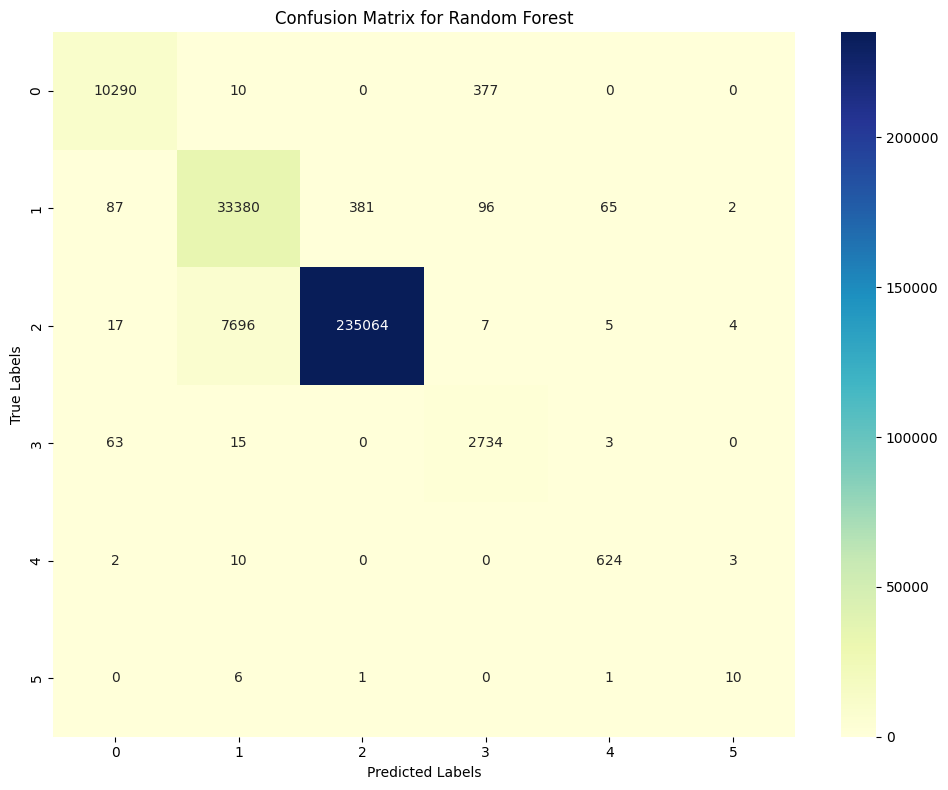

In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

rf_model = RandomForestClassifier(
    n_estimators=150,
    max_depth=15,
    min_samples_split=4,
    min_samples_leaf=2,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f" Random Forest Accuracy: {acc * 100:.2f}%")
print(" Randon Forest Classification Report:\n", report)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=True)

plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()


In [78]:
from sklearn.metrics import roc_auc_score, matthews_corrcoef, cohen_kappa_score
y_prob = rf_model.predict_proba(X_test)
try:
    roc_auc = roc_auc_score(
        y_test,
        y_prob,
        multi_class='ovr',        
        average='weighted'
    )
    print(f" Weighted ROC-AUC Score: {roc_auc:.4f}")
except ValueError:
    print(" ROC-AUC calculation failed (possibly due to 1 class in y_test)")

mcc = matthews_corrcoef(y_test, y_pred)
print(f" Matthews Correlation Coefficient (MCC): {mcc:.4f}")

kappa = cohen_kappa_score(y_test, y_pred)
print(f" Cohen’s Kappa Score: {kappa:.4f}")

 Weighted ROC-AUC Score: 0.9984
 Matthews Correlation Coefficient (MCC): 0.9042
 Cohen’s Kappa Score: 0.9008


In [79]:
import time
import pandas as pd
import numpy as np

y_test_array = y_test.values

start = time.time()
preds = rf_model.predict(X_test)  # batch prediction
end = time.time()

total_time_ms = (end - start) * 1000
avg_time_ms = total_time_ms / len(X_test)

correct_flags = (preds == y_test_array).astype(int)

inference_times = [avg_time_ms] * len(X_test)

df_rf = pd.DataFrame({
    'inference_time_ms': inference_times,
    'is_correct': correct_flags
})

df_rf.to_csv("Random Forest.csv", index=False)
print(" Saved: Random Forest.csv")
print(f" Avg Inference Time: {avg_time_ms:.4f} ms per sample")

 Saved: Random Forest.csv
 Avg Inference Time: 0.0028 ms per sample


C:\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [10:45:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 XGBoost Accuracy: 98.02%
 XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97     10677
           1       0.95      0.89      0.92     34011
           2       0.99      0.99      0.99    242793
           3       0.86      0.95      0.90      2815
           4       0.95      0.88      0.92       639
           5       0.55      0.33      0.41        18

    accuracy                           0.98    290953
   macro avg       0.88      0.84      0.85    290953
weighted avg       0.98      0.98      0.98    290953



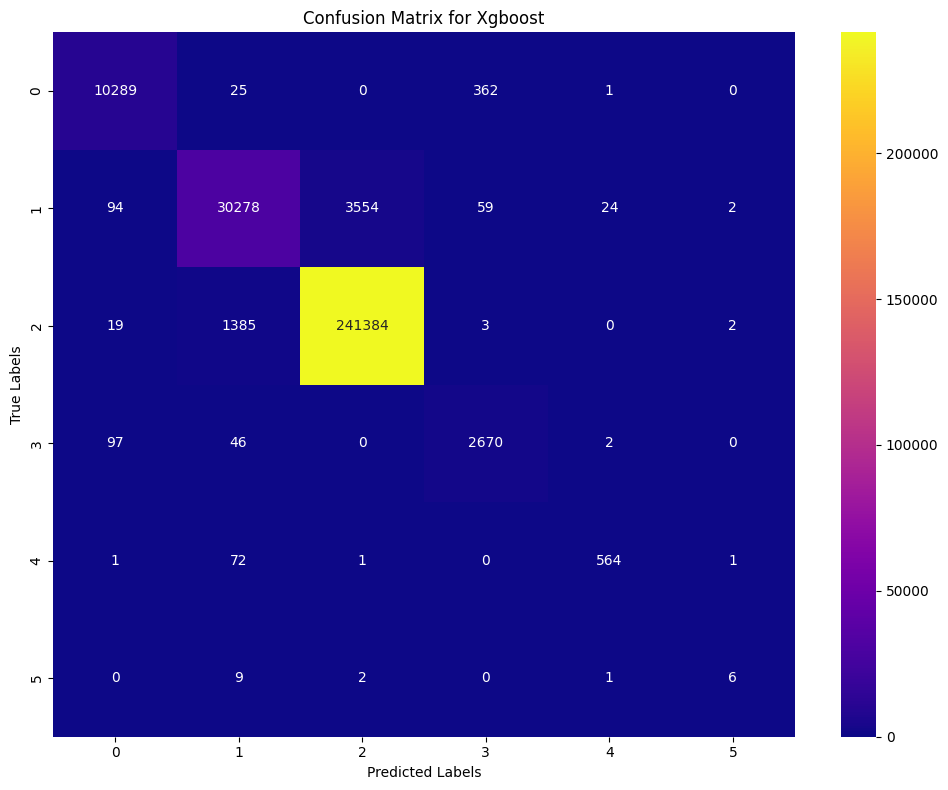

In [80]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(set(y_train)), 
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=150,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f" XGBoost Accuracy: {acc * 100:.2f}%")
print(" XGBoost Classification Report:\n", report)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='plasma', cbar=True)

plt.title('Confusion Matrix for Xgboost')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()


In [81]:
from sklearn.metrics import roc_auc_score, matthews_corrcoef, cohen_kappa_score

try:
    y_proba = xgb_model.predict_proba(X_test)

    roc_auc = roc_auc_score(
        y_test,
        y_proba,
        multi_class='ovr',        
        average='weighted'       
    )
    print(f" Weighted ROC-AUC Score: {roc_auc:.4f}")
except Exception as e:
    print(f" ROC-AUC could not be calculated: {e}")

# Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test, y_pred)
print(f" Matthews Correlation Coefficient (MCC): {mcc:.4f}")

# Cohen’s Kappa Score
kappa = cohen_kappa_score(y_test, y_pred)
print(f" Cohen’s Kappa Score: {kappa:.4f}")


 Weighted ROC-AUC Score: 0.9983
 Matthews Correlation Coefficient (MCC): 0.9304
 Cohen’s Kappa Score: 0.9301


In [82]:
import time
import pandas as pd
import numpy as np

y_test_array = y_test.values

start = time.time()
preds = xgb_model.predict(X_test) 
end = time.time()

total_time_ms = (end - start) * 1000
avg_time_ms = total_time_ms / len(X_test)

correct_flags = (preds == y_test_array).astype(int)

inference_times = [avg_time_ms] * len(X_test)

df_xgb = pd.DataFrame({
    'inference_time_ms': inference_times,
    'is_correct': correct_flags
})


df_xgb.to_csv("Xgboost.csv", index=False)
print(" Saved: Xgboost.csv")
print(f" Avg Inference Time: {avg_time_ms:.4f} ms per sample")

 Saved: Xgboost.csv
 Avg Inference Time: 0.0018 ms per sample


 Hypergraph Ensemble Accuracy: 97.44%
 Hypergraph Ensemble Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97     10677
           1       0.85      0.97      0.90     34011
           2       1.00      0.98      0.99    242793
           3       0.86      0.96      0.91      2815
           4       0.94      0.97      0.96       639
           5       0.67      0.44      0.53        18

    accuracy                           0.97    290953
   macro avg       0.88      0.88      0.88    290953
weighted avg       0.98      0.97      0.98    290953



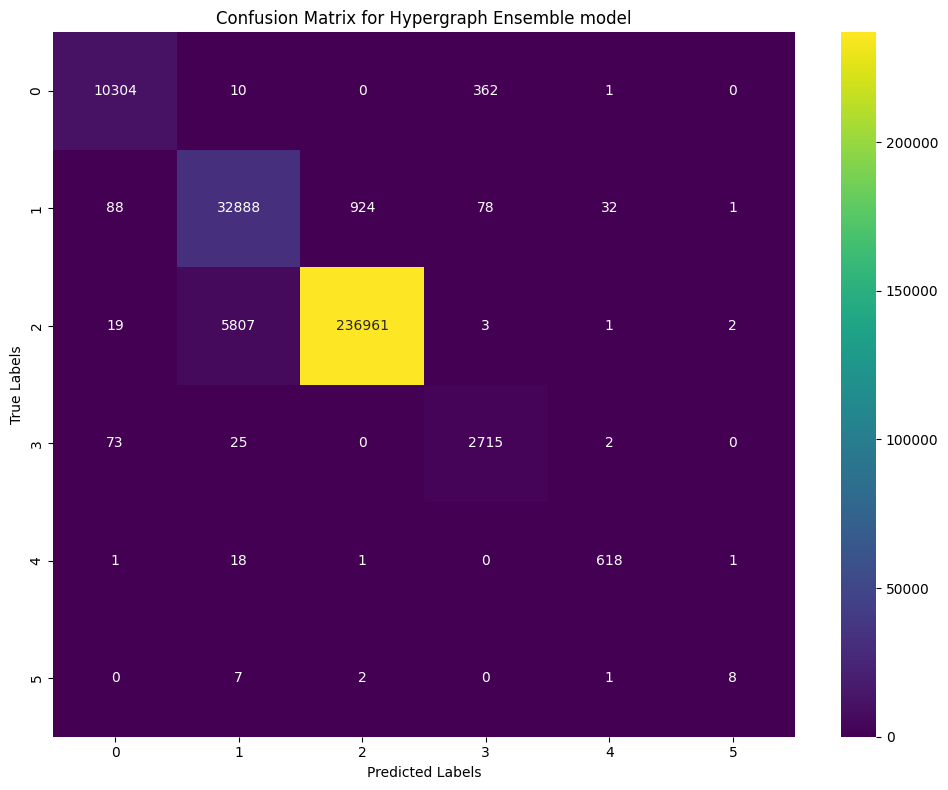

In [83]:
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=4,
    min_samples_leaf=2,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(set(y_train)),
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

ensemble_model = VotingClassifier(
    estimators=[('rf', rf_model), ('xgb', xgb_model)],
    voting='soft', 
    n_jobs=-1
)


ensemble_model.fit(X_train, y_train)

y_pred_ensemble = ensemble_model.predict(X_test)
acc = accuracy_score(y_test, y_pred_ensemble)
report = classification_report(y_test, y_pred_ensemble)
conf_matrix = confusion_matrix(y_test, y_pred_ensemble)


print(f" Hypergraph Ensemble Accuracy: {acc * 100:.2f}%")
print(" Hypergraph Ensemble Classification Report:\n", report)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', cbar=True)

plt.title('Confusion Matrix for Hypergraph Ensemble model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()


In [84]:
from sklearn.metrics import roc_auc_score, matthews_corrcoef, cohen_kappa_score

try:
    y_prob_ensemble = ensemble_model.predict_proba(X_test)

    roc_auc = roc_auc_score(
        y_test,
        y_prob_ensemble,
        multi_class='ovr',       
        average='weighted'      
    )
    print(f" Weighted ROC-AUC Score: {roc_auc:.4f}")
except Exception as e:
    print(f" ROC-AUC could not be calculated: {e}")

# Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_test, y_pred_ensemble)
print(f" Matthews Correlation Coefficient (MCC): {mcc:.4f}")

# Cohen's Kappa
kappa = cohen_kappa_score(y_test, y_pred_ensemble)
print(f" Cohen’s Kappa Score: {kappa:.4f}")


 Weighted ROC-AUC Score: 0.9985
 Matthews Correlation Coefficient (MCC): 0.9163
 Cohen’s Kappa Score: 0.9147


In [85]:
import time
import pandas as pd
import numpy as np

y_test_array = y_test.values

start = time.time()
pred_all = ensemble_model.predict(X_test) 
end = time.time()

total_time_ms = (end - start) * 1000
avg_time_ms = total_time_ms / len(X_test)

correct_flags = (pred_all == y_test_array).astype(int)


df_hypergraph = pd.DataFrame({
    'inference_time_ms': [avg_time_ms] * len(X_test),
    'is_correct': correct_flags
})

df_hypergraph.to_csv("Hypergraph Ensemble.csv", index=False)
print(" Saved: Hypergraph Ensemble.csv")
print(f" Avg Inference Time: {avg_time_ms:.4f} ms")
print(f" Accuracy: {np.mean(correct_flags) * 100:.2f}%")


 Saved: Hypergraph Ensemble.csv
 Avg Inference Time: 0.0031 ms
 Accuracy: 97.44%
